# Reproducibility Project
CS598 Deep Learning for Healthcare - Spring 2023

Orignal Paper: [Disease Prediction and Early Intervention System Based on Symptom Similarity Analysis](https://ieeexplore.ieee.org/document/8924757)<br>

_Contributors:_
 * Michael Pettenato - mp34@illinois.edu
 * Adam Michalsky - adamwm3@illinois.edu

## Dependencies
For this reproduction we have installed the below mentioned python libraries.

**Note**:
- If you are using the conda python environment you should be able to use the ./packages/packages.txt file to recreate the virtual environment. This can be done by running the following command:
     - conda create -name <env_name> -file ./requirements-conda.txt
- If you are using a pip based python interpreter you can follow these steps
     - mkdir myproject
     - cd myproject
     - python -m venv myenv
     - source myenv/bin/activate # for linux
     - myenv\Scripts\activate.bat # for windows
     - pip install -r requirements.txt # where 'requirements.txt' file is the one located in the root directory of this project

**Dependency list**
1. gensim-4.3.0
2. jupyter-1.0.0
3. jupyter-client-8.1.0
4. jupyter-console-6.6.3
5. jupyter-core-5.3.0
6. jupyter-server-1.23.4
7. jupyter_server-1.23.4
8. jupyterlab-3.5.3
9. jupyterlab_pygments-0.1.2
10. jupyterlab_server-2.21.0
11. jupyterlab_widgets-3.0.5
12. matplotlib-3.7.1
13. numpy-1.23.5
14. pandas-1.5.2
13. pytorch 2.0
14. scikit-learn-1.2.0
15. scipy-1.10.0
16. spacy-3.3.1
17. stanza-1.5.0
18. tqdm-4.65.0



## Introduction

When physicians work with their patients, they often start by listening to their patient's symptom statements. The physcian will then map the patient's sympton statements to the symptoms that have been cataloged by the healthcare industry. This process or task of assess similarity between two sentences (e.g., A patient's symptom statement _and_ The cataloged symptom) is a task that can be easily mapped into computing.

Sentence similarity is a task that has had significant research done on it already. Deep learning models were developed to perform this task in the healthcare industry already but each model has its pros and cons. One of the most common traits of models that assess similarity is the training time required, which is what the original paper (cited above) aimed to solve using an approach comprised of leveraging a Stanford Parser, Word2Vec embedding, and a convolutional neural network (CNN) based model.  

The original paper did not have a documented repository, but did offer pseudo-code for certain aspects of the experiment. The following notebook is a reproduction of the original paper with some ablations that will be called out. 

In [53]:
import datetime
import gensim
import multiprocessing
import numpy as np
import os.path
import pandas as pd
import torch, stanza,spacy
from torch import nn
from torch.utils.data import Dataset, DataLoader
from enum import Enum
from gensim.models import Word2Vec
import threading
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

## About the Data

The data that will be used to train and test is sourced from [Microsoft Research Paraphrase Corpus](https://www.microsoft.com/en-us/download/details.aspx?id=52398). 


### Helper Functions

Below we define helper functions for ingesting the data used in the experiments.
* `read_file` - This will be used to read in local files containing data.

In [54]:
def read_file(file_name):
    # Note: Unable to use pd.read_csv... the function complained about an issue with the formatting of the tsv file
    # train = pd.read_csv('data/msr_paraphrase_train.txt', sep='\t', encoding='latin1')
    # train

    # opting to read file in and split columns manually to create a pandas dataframe
    list = []
    with open(file_name, encoding="utf8") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            fields = line.split('\t')
            list.append(fields)

    df = pd.DataFrame(list[1:], columns=['Quality', 'ID1', 'ID2', 'String1', 'String2'])
    return df

## Approach

The approach described in the original paper can be described in three seperate _stages_. 

1) **Data Pre-Processing** - Here we will read in the raw data, parse it using the described algorithm, and prepare the parsed data by performing embedding using `Word2Vec`.

2) **Neural Network** - Here we build the CNN-based model described in the original paper. This CNN will take the vectorized sentences pairs as inputs and return a similarity assesment [0,1].  No specifics of network architecture were offered in the original paper so the architecture is based on the our own knowledge.

3) **Training & Validation** - Here we train and test the model using the data and network established in the previous stages.
<br>
<br>


<div>
    <figure>
        <img src="./images/overview.png" width="500"/>
        <figcaption align='center'>Figure 1: Overview of the Approach</figcaption>
    </figure>
</div>

## Data Pre-processing

In data pre-processing, perform two critical functions:

   1. Read in and parse the two files stored `.\data` directory.
      - msr_paraphrase_data.txt (training data)
      - msr_paraphrase_test.txt (test data)

   2. Embed the parsed sentences using `Word2Vec` embedding.

Data parsed is stored in a custom dataset using PyTorch class `Dataset`. Our implementation is `MSPCDataset`. This will allow us to take advantage of PyTorch's `DataLoader` functionality, which has data batching facilities.  The `MSPCDataset` produced an output format shown in the equation below.

\begin{equation}
Item=(Sent1, Sent2, SimFlag)
\label{eq:Item}
\end{equation}

$Sent1$ and $Sent2$ have a format like $Sen$, discussed in the *Embedding with `Word2Vec`* section below, and $SimFlag$ is a binary target value, `0` being not similar and `1` being similar.

### Parsing 
<br>

The original paper used the Stanford Parser to find the parts of speech for each word in a sentence. This parser has been deprecated in favor of the `stanza` parser, so we used this as a replacement for the Stanford parser.


_Ablation 1:_After reviewing the algorithm defined in the paper and the output the `stanza` parser produced with it, we questioned its effectiveness and correctness.  We did not agree with the subject, predicate, and object (SPO) result 100% of the time. Therefore, the decision was made to support alternative parsing approaches. In addition to `stanza`, we have introduced support for two more parsing methods:
* `spaCy` - Documentation and install instructions can be found at their [site](https://spacy.io/usage).
* `Raw` - A method where raw sentences are used. 

To allow flexibility in coding we have defined enum values for each parse method:
 * `STANZA` - Stanford Parser(`stanza`)
 * `SPACY` - spaCy Parser
 * `RAW` - Raw sentences are embedded using `Word2Vec`.

Our goal was to understand the effectiveness of the parsing algoirithm defined in the paper

In [55]:
class Parsing(Enum):
    STANZA=1
    SPACY=2
    RAW=3

##### Stanford Parser (`stanza`)

As mentioned above, the Stanford Parser was what was used by the original paper to parse its raw sentences so we were able to reproduce the custom logic used to parse the tree produced by the parser. For ease of use, we implemented a function designed to extract _subject(s)_, _predicate(s)_, and _object(s)_ from an input parse tree (Figure 2). Going forward this will be referred to as a _SPO Kernel Function_.


<div>
    <figure>
        <img src="./images/parsetree.png" width="500"/>
    </figure>
</div>

<br> 

In **Section III** of the original paper, the _SPO Kernel Function_ is discussed along with some pseudo-code.  We observed that the paper had discrepancies, where the pseudo-code did not match the textual description, found in the trunk construction algorithm.  We implemented our parsing algorithm according to the textual description, which was more detailed than the pseudo-code provided.

###### Helper Functions

Below we haved defined several functions that aid in finding the SPO provided a parsed sentence tree obtained from a `stanza` parser. 

* `find_branches()` - Extract phrases from a provided tree given a list of labels to include and exclude.
* `find_subject()` - Locate a _subject_ given a noun phrase.
    * _subject_ - Any `NN` child found in a noun phrase extracted from the parse tree.
* `find_predicate()` - Locate a _predicate_ given a verb phrase.
    * _predicate_ - Any `VB`child found in a verb phrase extracted from the parse tree.
* `find_object()` - Locate an _object_ given a verb phrase.
   * _object_ - Any `NN` child of a `NP`, `PP`, or `ADJP`object OR any child object that is not a `VP`found in the verb phrase extracted from the parse tree.

In [56]:
def find_branches(tree, label, not_in_label=None, ancestors=[]):
    branches = []
    # print("-------------")
    # print(ancestors)
    # print(f"{tree.label} == {label}")
    if tree.label == label and not_in_label not in ancestors:
        # print(f"adding {tree}")
        branches.append(tree)
    for child in tree.children:
        branches = branches + find_branches(child, label, not_in_label, ancestors + [tree.label])

    return branches

#
# # According to the paper the subject is the first NN child of NP
def find_subject(noun_phrase_for_subject):
    subject = []
    for child in noun_phrase_for_subject.children:
        if 'NN' in child.label:
            subject = subject + child.leaf_labels()

    #print(f"subject = {subject}")
    #if len(subject) > 0:
    #    return ' '.join(subject)
    return subject

    return None

def find_predicate(verb_phrase_for_predicate):
    predicate = []
    for child in verb_phrase_for_predicate.children:
        if child.label.startswith('VB'):
            predicate = predicate + child.leaf_labels()

    if len(predicate) > 0:
        return ' '.join(predicate)

    return None

def find_object(verb_phase_for_object, parent='VP'):
    objects = []
    for child in verb_phase_for_object.children:
        if child.label == 'VP':
            continue
        if 'NN' in child.label and parent in ['NP', 'PP', 'ADJP']:
            #objects = objects + child.leaf_labels()
            new_objects = child.leaf_labels()
            for new_object in new_objects:
                if new_object not in objects:
                    objects.append(new_object)
        else:
            new_objects = find_object(child, child.label)
            #if new_objects not in objects and new_objects is not None:
            for new_object in new_objects:
                if new_object not in objects:
                    objects.append(new_object)
                #objects = objects + new_objects

    return objects
    # if len(objects) > 0:
    #     #return ' '.join(objects)
    #     return objects
    # else:
    #     return None

###### SPO Kernel Function

In [57]:
def find_spo(tree):
    noun_phrases_for_subject = find_branches(tree, label='NP', not_in_label='VP', ancestors=[])
    subject_list = []
    for noun_phrase_for_subject in noun_phrases_for_subject:
        subject = find_subject(noun_phrase_for_subject)
        #if subject is not None:
        #   subject_list.append(subject)
        subject_list = subject_list + subject

    verb_phrases = find_branches(tree, label='VP')
    predicate_list = []
    object_list = []
    for verb_phrase in verb_phrases:
        predicate = find_predicate(verb_phrase)
        if predicate is not None:
            predicate_list.append(predicate)
        object = find_object(verb_phrase)
        object_list = object_list + object
        #if object is not None:
        #    object_list.append(object)

    # dedupe list
    subject_list = list(dict.fromkeys(subject_list))
    predicate_list = list(dict.fromkeys(predicate_list))
    object_list = list(dict.fromkeys(object_list))

    return subject_list, predicate_list, object_list

#### SpaCy Parser
Spacy library is a relatively new parser that has gained much popularity due to its speed and ease of use.

Similar to the Stanford Parser, a _SPO Function_ is implemented to traverse a sentence _tree_ or `doc` to locate the SPO.
Words are tagged with a parts of speech parser.  Based on the spacy parser tagging the subject, predicate and object are relatively easy to extract.
Our goal for using a different parser with a relatively straight forward way to extract the subject, predicate, and object was to see if the more complicated variance, described in the paper was improving the similarity scores.

The SPO extraction algorithm for the spacy parser can be seen in the `find_spacy_spo()` function below.

###### SPO Kernel Function

In [58]:
def find_spacy_spo(doc):
    # Extract the subject, predicate, and object
    subject = []
    predicate = []
    obj = []

    for token in doc:
        #print(f"{token.dep_} : {token.text}")
        if "subj" in token.dep_:
            subtree = list(token.subtree)
            start = subtree[0].i
            end = subtree[-1].i + 1
            subject .append(doc[start:end])
        elif "obj" in token.dep_ or "pcomp" in token.dep_:
            obj.append(token.text)
        elif "ROOT" in token.dep_ or "pred" in token.dep_:
            predicate.append(token.text)

    # Print the results
    # print("Subject: ", subject)
    # print("Predicate: ", predicate)
    # print("Object: ", obj)
    return subject, predicate, obj

#### Raw

No specialized _SPO Kernel Function_ is required.
This parsing approach used the gensim
- `gensim.utils.simple_preprocess`
- `gensim.parsing.preprocessing.remove_stopwords`
- `gensim.parsing.preprocessing.strip_short'

To remove the stopwords, any word that is two characters or less and tokenize the remaining words in the sentence.
This was done to see how useful SPO parsing wsa to the accuracy and training time of the model.

#### Concurreny Support

After implementation of the _SPO Functions_, the original paper began replacing words with embedding vectors, using `Word2Vec`. Before we started the embedding process, we decided to further improve the speed of parsing by implementing concurrency.

_Ablation 2:_ We found the stanza parts-of-speech parsing to be slow.  In order to speed it up we implemented a multi-threaded parsing class called `SentenceProcessingThread`.

This class instantiates a parser based on the enumerated `Parsing` types and performs the specified parsing method against the input sentences.

In [59]:
class SentenceProcessingThread(threading.Thread):
    def __init__(self, sentences, output_list, begin, end, parsing_enum=Parsing.STANZA):
        super(SentenceProcessingThread, self).__init__()
        self.sentences = sentences
        self.parsing_enum = parsing_enum

        if parsing_enum == Parsing.STANZA:
            self.nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', download_method=None, use_gpu=True)
        else:
            try:
                self.nlp = spacy.load('en_core_web_sm')
            except TypeError:
                print("Exception")
                print()
        self.output_list = output_list
        self.begin = begin
        self.end = end

    def trunk_construction(self, str, parent_label = None):
        doc = self.nlp(str)

        #words = construct_sentence(tree, parent_label)
        #return ' '.join(words)

        if self.parsing_enum == Parsing.SPACY:
            subjects, predicates, objects = find_spacy_spo(doc)
        else:
            tree = doc.sentences[0].constituency
            subjects, predicates, objects = find_spo(tree)

        return f"{' '.join(subjects)},{' '.join(predicates)},{' '.join(objects)}"

    def run(self):
        print(f"going to process {self.begin} to {self.end}")
        for i, sentence in enumerate(self.sentences):
            new_sentence = self.trunk_construction(sentence)
            self.output_list[self.begin + i] = new_sentence


Below we implement functions to facilitate parsing using `SentenceProcessingThread`. To further improve performance we added support to detect and use GPUs if GPUs are available on the host machine. If GPUs are unavailable, the parsing process will simply utilitze CPUs with the appropriate number of threads.

* `process_sentences_concurrently` - Processes the provided `sentences` across `p` threads and stores the processed sentence in the `output`.

* `preprocess_corpus` - Reads sentences in an `input_file` containing sentences to parse using the provided parsing method (`parsing_enum`) and saves the result in the `output_file`.

In [60]:
def process_sentences_concurrently(sentences, output, p=2, parsing_enum=Parsing.STANZA):
    total = len(sentences)
    interval = int(total / p)
    threads = []
    for i in range(p):
        s = i*interval
        if i == p-1:
            e = total
        else:
            e = (i+1) * interval
        sentences_slice = sentences[s:e]
        sentence_thread = SentenceProcessingThread(sentences_slice, output, s, e, parsing_enum=parsing_enum)
        sentence_thread.start()
        threads.append(sentence_thread)

    for thread in threads:
        thread.join()

def preprocess_corpus(input_file='data/msr_paraphrase_train.txt', output_file='data/msr_paraphrase_train_stanza.txt', N=None, parsing_enum=Parsing.STANZA, p=None):
    if os.path.exists(output_file):
        print(f"{output_file} already exists")
        return

    print(f"Going to write to {output_file}")

    starttime = datetime.datetime.now()
    df = read_file(input_file)

    if N is None:
        N = len(df.String1)

    output1 = [None] * N
    output2 = [None] * N

    if p is None:
        # we can process with more threads if we only have CPU
        num_cores_cpu = multiprocessing.cpu_count()
        print(f"discovered that CPU has a total of {num_cores_cpu} cores and hyperthreads")
        p = num_cores_cpu

        if torch.cuda.is_available():
            # if cuda is available we don't need that many threads
            # and if the number of threads is set too large using cuda
            # we can get out of memory exceptions
            # This value is dependent on the number of cores in your graphics card.
            p = 2
            torch.cuda.empty_cache()

    process_sentences_concurrently(df.String1[:N], output1, p, parsing_enum=parsing_enum)

    # try and be careful with gpu memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    process_sentences_concurrently(df.String2[:N], output2, p)

    endtime = datetime.datetime.now()

    print(f"time to process {N*2} sentences is {endtime - starttime}")

    stanza_df = df[:N]

    processed_string1 = pd.Series(output1)
    # processed_string1.apply(gensim.utils.simple_preprocess)
    processed_string2 = pd.Series(output2)
    #processed_string2.apply(gensim.utils.simple_preprocess)

    stanza_df.String1 = processed_string1
    stanza_df.String2 = processed_string2

    # write the file out.  This can help in the future
    print(f"about to write out {output_file}")
    stanza_df.to_csv(output_file, sep="\t")

In order to demonstrate the benefit of concurrency support we felt it was best to quantify it. Below are the functions we used.

In [61]:
from tqdm import tqdm

def seq_trunk_construction(nlp, sentence):
    doc = nlp(sentence)
    tree = doc.sentences[0].constituency

    subjects, predicates, objects = find_spo(tree)

    return f"{' '.join(subjects)},{' '.join(predicates)},{' '.join(objects)}"
    
def seq_process_sentence(sentences, output_list):
    nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', download_method=None, use_gpu=True)

    
    for i, sentence in enumerate(tqdm(sentences, desc="Stanza Parsing...")):
        new_sentence = seq_trunk_construction(nlp, sentence)
        output_list[i] = new_sentence
    
def time_seq_processing(input_file='data/msr_paraphrase_train.txt', output_file='data/msr_paraphrase_train_stanza.txt', N=None):

    df = read_file(input_file)

    if N is None:
        N = len(df.String1)

    output1 = [None] * N
    output2 = [None] * N

    #Time Sequential Stanza parsing
    stanza_starttime = datetime.datetime.now()
    seq_process_sentence(df.String1[:N], output1)
    seq_process_sentence(df.String2[:N], output2)
    stanza_endtime = datetime.datetime.now()
    #Time Sequential SpaCy parsing

    stanza_runtime = stanza_endtime - stanza_starttime
    return stanza_runtime

The function, `time_seq_processing()` will return the runtime of sequentially parsing the training data. Our runtime result is `4:13:13.276852`. The function is commented out below for convenience. We will compare the parsing times after we create our dataloaders below.

In [62]:
# Only run if you have patience!
# seq_runtimes = time_seq_processing()


# Previously recorded runtime of sequential stanza parsing
# 4:13:13.276952 
seq_runtimes = datetime.datetime.strptime('4:13:13.276952', '%H:%M:%S.%f')

# Print runtime
print(seq_runtimes.strftime('%H:%M:%S.%f'))


04:13:13.276952


#### Embedding with `Word2Vec`

Each word in the sentence needs to be replaced by an embedding vector. Consistent with the information described in the original paper, we used Word2Vec, with an embedding size of 50.  The following equation describes a word $W$ in vector form:

<br>
\begin{equation} 
W=(\mathbf {w}^1, \mathbf {w}^2,...,\mathbf {w}^n)
\label{eq:Word}
\end{equation}
<br>
where $w$ represents an embedding vector and the superscript represents the sequence of words in a sentence.
<br><br>
The next equation shows how the sentence is further organized
<br>
\begin{equation} 
Sen=(\mathbf {S}^{\mathrm {T}}, \mathbf {P}^{\mathrm {T}}, \mathbf {O}^{\mathrm {T}})
\label{eq:Sent}
\end{equation}
<br>
where $S^T$, $P^T$, $O^T$ represent the subject, predicate, and object words, all with a similar structure to $W$.


The original paper did not provide details on how their `Word2Vec` model was trained. This is the motivation for our next ablation.

_Ablation 3_: Due to the uncertainty of how the original paper's `Word2Vec` model was trained, we opted to try two different models:
1) A Word2Vec model that is trained on MSRP corpus. 
2) A pre-trained Word2Vec model.

##### Pre-trained Model Details

For our comparison, we chose to leverage one trained on Google News vectors from `gensim`. For further documentation please see their [website](https://radimrehurek.com/gensim/models/word2vec.html).

**WARNING:** The following code block is to download the pre-trained model mentioned above and it takes several minutes to complete!

Please be advised that some default jupyter settings will need to be modified to ensure a successful download. We modfied the `c.NotebookApp.iopub_data_rate_limit` setting to 100000000.

Instructions on how to create a configuration file and to modify the variable can be found [here](https://stackoverflow.com/questions/43490495/how-to-set-notebookapp-iopub-data-rate-limit-and-others-notebookapp-settings-in).

In [63]:
import gensim.downloader as api
pretrained_word2vec_path = api.load("word2vec-google-news-300", return_path=True)
print(pretrained_word2vec_path)

C:\Users\migzv/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


##### Fake Word Embedding

When using a pretrained word2vec model there may be some words that don't appear in the vocabulary for the pretrained model.  In our experiment this occured with people's names, which appeared in sentences from news articles.  There are a few ways to handle this, for instance you could ignore the word that does not appear in the vocabulary, or you could train word2vec with that additional information in the corpus. Due to the fact that the words that were missing were mostly firstnames or surnames, we decided to generate a fake word embedding.  The requirement of the word embedding was to be real numbers between -0.5 and 0.5 with a euclidean norm of the array equal to 1.


In [64]:
fake_embeddings = {}
def get_fake_embedding(word, size):

    if word in fake_embeddings:
        return fake_embeddings[word]

    embedding = np.random.rand(size) - 0.5

    # Calculate the Euclidean norm of the array
    norm = np.linalg.norm(embedding)

    embedding /= norm

    return embedding

Below, we implemented the following functions:

* `generate_word2vec_model(corpus)` - Create a `Word2Vec` model given a `corpus`.
* `sentence_embeddings(w2v_model, sentence, size)` - Embed a `sentence` of length `size` using a provided `Word2Vec` model, `w2vmodel`.
* `corpus_embeddings(model, corpus, max_sentence_len)` - Embed a `corpus` with a maximum sentence length of `max_sentence_len` using a provided model, `model`. 
* `init_word2vec(train_input_file, test_input_file, parsing_enum)` - Provided `train_input_file`, `test_input_file`, and a parsing method identified by `parsing_enum`, this function will return a tuple containing a `Word2Vec` model trained on the MSRP corpus dataset along with the maximum sentence length, `max_sentence_length` for all the sentences in a corpus. 

In [65]:
# Function is broken out for testing purposes
def generate_word2vec_model(corpus):
    # Creating the Word2Vec model
    model = Word2Vec(sentences=corpus, min_count=1, window=2, vector_size=50)

    return model


In [66]:
# Function is broken out for testing purposes
def sentence_embeddings(w2v_model, sentence, size):
    np_embedding = np.zeros(size)
    for i, word in enumerate(sentence):
        #print(word)
        if hasattr(w2v_model, "wv"):
            np_embedding[i] = w2v_model.wv.get_vector(word)
        else:
            try:
                np_embedding[i] = w2v_model.get_vector(word)
            except KeyError:
                print(f"Word {word} was not found in the vocabulary")
                np_embedding[i] = get_fake_embedding(word, size[1])
                print("Generated a fake embedding ", np_embedding[i])

    return np_embedding
    # list = []
    # for word in sentence:
    #     list.append(w2v_model.wv.get_vector(word))
    #
    # word_matrix = np.row_stack(list)
    # #return np.mean(word_matrix, axis=0)
    # return word_matrix

In [67]:
def corpus_embeddings(model, corpus, max_sentence_len, embedding_size=50):
    corpus_size = len(corpus)
    embeddings_list = []
    embedding_matrix = np.zeros((corpus_size, max_sentence_len, embedding_size))
    for i, sentence in enumerate(corpus):
        embeddings = sentence_embeddings(model, sentence, size=(max_sentence_len, embedding_size))
        embedding_matrix[i] = embeddings
        embeddings_list.append(embeddings)

    return embedding_matrix

In [68]:
def init_word2vec(train_input_file, test_input_file, parsing_enum=Parsing.STANZA):

    if parsing_enum == Parsing.RAW:
        train_output_file = train_input_file
        test_output_file = test_input_file
        train_df = read_file(train_output_file)
        test_df = read_file(test_output_file)

    elif parsing_enum == Parsing.STANZA:
        file_parts = os.path.splitext(train_input_file)
        train_output_file = f"{file_parts[0]}_stanza{file_parts[1]}"
        print("About to preprocess spacy data")
        preprocess_corpus(input_file=train_input_file, output_file=train_output_file, parsing_enum=parsing_enum)
        print("Done preprocessing spacy data")

        file_parts = os.path.splitext(test_input_file)
        test_output_file = f"{file_parts[0]}_stanza{file_parts[1]}"
        print("About to preprocess data")
        preprocess_corpus(input_file=test_input_file, output_file=test_output_file, parsing_enum=parsing_enum)
        print("Done preprocessing data")
        train_df = pd.read_csv(train_output_file, sep="\t")
        test_df = pd.read_csv(test_output_file, sep="\t")
    else:
        file_parts = os.path.splitext(train_input_file)
        train_output_file = f"{file_parts[0]}_spacy{file_parts[1]}"
        print("About to preprocess spacy data")
        preprocess_corpus(input_file=train_input_file, output_file=train_output_file, parsing_enum=parsing_enum)
        print("Done preprocessing spacy data")

        file_parts = os.path.splitext(test_input_file)
        test_output_file = f"{file_parts[0]}_spacy{file_parts[1]}"
        print("About to preprocess data")
        preprocess_corpus(input_file=test_input_file, output_file=test_output_file, parsing_enum=parsing_enum)
        print("Done preprocessing data")
        train_df = pd.read_csv(train_output_file, sep="\t")
        test_df = pd.read_csv(test_output_file, sep="\t")

    # train_df = read_file(train)
    # test_df = read_file(test)

    train_sentences1 = train_df.String1.apply(gensim.utils.simple_preprocess)
    train_sentences2 = train_df.String2.apply(gensim.utils.simple_preprocess)
    test_sentences1 = test_df.String1.apply(gensim.utils.simple_preprocess)
    test_sentences2 = test_df.String2.apply(gensim.utils.simple_preprocess)

    corpus = pd.concat([train_sentences1, train_sentences2, test_sentences1, test_sentences2], ignore_index=True)
    max_sentence_len = corpus.apply(len).max()

    word2vec = generate_word2vec_model(corpus)


    return word2vec, max_sentence_len


#### Custom Dataset: `MSPCDataset`

Our custom dataset is implemented as follows:

In [69]:
# Dataset for the MSPC dataset
class MSPCDataset(Dataset):
    """
    Arguments:
        tsv_file (string): path to the tsv file with sentences to compare and associate quality score
        num_records (int): number of records to load.  Defaults to None which is all
    """
    def __init__(self, tsv_file, w2v_model, max_sentence_length, num_records=None, parsing_enum=Parsing.STANZA, embedding_size=50):

        self.max_sentence_len = max_sentence_length
        self.w2v_model = w2v_model

        if parsing_enum == Parsing.STANZA:
            file_parts = os.path.splitext(tsv_file)
            output_file = f"{file_parts[0]}_stanza{file_parts[1]}"
            print("About to preprocess stanza data")
            preprocess_corpus(input_file=tsv_file, output_file=output_file, parsing_enum=parsing_enum)
            print("Done preprocessing stanza data")
            #df = read_file('data/msr_paraphrase_train.txt')
            df = pd.read_csv(output_file, sep="\t")
        elif parsing_enum == Parsing.SPACY:
            file_parts = os.path.splitext(tsv_file)
            output_file = f"{file_parts[0]}_spacy{file_parts[1]}"
            print("About to preprocess spacy data")
            preprocess_corpus(input_file=tsv_file, output_file=output_file, parsing_enum=parsing_enum)
            print("Done preprocessing spacy data")
            #df = read_file('data/msr_paraphrase_train.txt')
            df = pd.read_csv(output_file, sep="\t")
        else:
            df = read_file(tsv_file)

        if num_records is not None:
            processed_string1 = df[:num_records].String1
            processed_string2 = df[:num_records].String2
            self.quality = df[:num_records].Quality
        else:
            processed_string1 = df.String1
            processed_string2 = df.String2
            self.quality = df.Quality

        if parsing_enum == Parsing.RAW:
            processed_string1 = processed_string1.apply(gensim.parsing.preprocessing.remove_stopwords)
            processed_string2 = processed_string2.apply(gensim.parsing.preprocessing.remove_stopwords)
            processed_string1 = processed_string1.apply(lambda x: gensim.parsing.preprocessing.strip_short(x, minsize=3))
            processed_string2 = processed_string2.apply(lambda x: gensim.parsing.preprocessing.strip_short(x, minsize=3))

        processed_string1 = processed_string1.apply(gensim.utils.simple_preprocess)
        processed_string2 = processed_string2.apply(gensim.utils.simple_preprocess)


        print(processed_string1)


        #corpus = pd.concat([processed_string1, processed_string2], ignore_index=True)
        #self.max_sentence_len = corpus.apply(len).max()
        #w2v_model = generate_word2vec_model(corpus)

        sentence_embeddings1 = corpus_embeddings(self.w2v_model, processed_string1, max_sentence_len=self.max_sentence_len, embedding_size=embedding_size)
        sentence_embeddings2 = corpus_embeddings(self.w2v_model, processed_string2, max_sentence_len=self.max_sentence_len, embedding_size= embedding_size)

        #self.w2v_model = w2v_model
        self.sentences_embeddings1 = sentence_embeddings1
        self.sentences_embeddings2 = sentence_embeddings2

        # print (f"Processing 200 sentences with gensim.utils.simple_preprocess took {end_time - start_time}")
        print(f"Number of sentences processed in the String1 column: {len(processed_string1)}")
        print(f"Number of sentences processed in the String2 column: {len(processed_string2)}")
        #print(self.sentences_embeddings1)

    def __len__(self):
        return len(self.sentences_embeddings1)

    def __getitem__(self, i):
        #return torch.FloatTensor(np.stack((self.sentences_embeddings1[i], self.sentences_embeddings2[i]))), self.quality[i]
        return torch.FloatTensor(self.sentences_embeddings1[i]), torch.FloatTensor(self.sentences_embeddings2[i]), self.quality[i]

    def get_max_sentence_length(self):
        return self.max_sentence_len

#### Pre-processing Validations

<br>
Below we are simply validating that the output is what expected when using either parsing method.
<br>

##### Stanford Parser (`stanza`) Validations


_MSRP Corpus Trained Word2Vec:_

In [70]:
def test_dataset():
    word2vec, max_sentence_length = init_word2vec('data/msr_paraphrase_train.txt', 'data/msr_paraphrase_test.txt', parsing_enum=Parsing.STANZA)
    dataset = MSPCDataset('data/msr_paraphrase_train.txt', word2vec, max_sentence_length, 10)
    assert len(dataset) == 10

    x1, y1, quality = dataset[0]
    assert x1.shape[0] == max_sentence_length
    assert x1.shape[1] == 50

test_dataset()

About to preprocess spacy data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing spacy data
About to preprocess data
data/msr_paraphrase_test_stanza.txt already exists
Done preprocessing data
About to preprocess stanza data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing stanza data
0    [amrozi, accused, called, distorting, brother,...
1    [yucaipa, owned, selling, dominick, chain, saf...
2    [had, published, offering, added, advertisemen...
3    [gmt, tab, shares, were, having, set, cents, h...
4    [stock, rose, close, percent, friday, stock, e...
5    [revenue, quarter, year, dropped, percent, per...
6        [nasdaq, had, closing, gain, percent, friday]
7          [dvd, cca, appealed, state, supreme, court]
8               [compared, cents, share, year, period]
9    [said, does, fit, business, company, growth, s...
Name: String1, dtype: object
Number of sentences processed in the String1 column: 10
Number of sentences processed in the 

_Pre-trained Word2Vec (Google News Vectors):_

In [71]:
def test_dataset_with_pretrained_word2vec():
    word2vec, max_sentence_length = init_word2vec('data/msr_paraphrase_train.txt', 'data/msr_paraphrase_test.txt', parsing_enum=Parsing.STANZA)
    print("Initiating a pretrained model for word2vec... this may take a while")
    #word2vec_pretrained = gensim.models.keyedvectors.load_word2vec_format('data/w2v/Google-news-vectors.bin.gz', binary=True)
    word2vec_pretrained = gensim.models.keyedvectors.load_word2vec_format(pretrained_word2vec_path, binary=True)
    print("Done initiating the pretrained model for word2vec")
    dataset = MSPCDataset('data/msr_paraphrase_train.txt', word2vec_pretrained, max_sentence_length, 10, embedding_size=300)
    assert len(dataset) == 10
    #
    x1, y1, quality = dataset[0]
    assert x1.shape[0] == max_sentence_length
    assert x1.shape[1] == 300

test_dataset_with_pretrained_word2vec()

About to preprocess spacy data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing spacy data
About to preprocess data
data/msr_paraphrase_test_stanza.txt already exists
Done preprocessing data
Initiating a pretrained model for word2vec... this may take a while
Done initiating the pretrained model for word2vec
About to preprocess stanza data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing stanza data
0    [amrozi, accused, called, distorting, brother,...
1    [yucaipa, owned, selling, dominick, chain, saf...
2    [had, published, offering, added, advertisemen...
3    [gmt, tab, shares, were, having, set, cents, h...
4    [stock, rose, close, percent, friday, stock, e...
5    [revenue, quarter, year, dropped, percent, per...
6        [nasdaq, had, closing, gain, percent, friday]
7          [dvd, cca, appealed, state, supreme, court]
8               [compared, cents, share, year, period]
9    [said, does, fit, business, company, growth, s...
Name

##### SpaCy Parser Validations

In [72]:
def test_dataset_spacy_sentences():
    word2vec_spacy, max_sentence_length_spacy = init_word2vec('data/msr_paraphrase_train.txt', 'data/msr_paraphrase_test.txt', parsing_enum=Parsing.SPACY)
    dataset = MSPCDataset('data/msr_paraphrase_train.txt', word2vec_spacy, max_sentence_length_spacy, 10, parsing_enum=Parsing.SPACY)
    assert len(dataset) == 10

    x1, y1, quality = dataset[0]
    assert x1.shape[0] == max_sentence_length_spacy
    assert x1.shape[1] == 50

test_dataset_spacy_sentences()

About to preprocess spacy data
data/msr_paraphrase_train_spacy.txt already exists
Done preprocessing spacy data
About to preprocess data
data/msr_paraphrase_test_spacy.txt already exists
Done preprocessing data
About to preprocess spacy data
data/msr_paraphrase_train_spacy.txt already exists
Done preprocessing spacy data
0    [amrozi, accused, called, distorting, brother,...
1    [yucaipa, owned, selling, dominick, chain, saf...
2    [had, published, offering, added, advertisemen...
3    [gmt, tab, shares, were, having, set, cents, h...
4    [stock, rose, close, percent, friday, stock, e...
5    [revenue, quarter, year, dropped, percent, per...
6        [nasdaq, had, closing, gain, percent, friday]
7          [dvd, cca, appealed, state, supreme, court]
8               [compared, cents, share, year, period]
9    [said, does, fit, business, company, growth, s...
Name: String1, dtype: object
Number of sentences processed in the String1 column: 10
Number of sentences processed in the Strin

##### Raw Parser Validations

In [73]:
def test_dataset_raw_sentences():
    word2vec_raw, max_sentence_length_raw = init_word2vec('data/msr_paraphrase_train.txt', 'data/msr_paraphrase_test.txt', Parsing.RAW)
    dataset = MSPCDataset('data/msr_paraphrase_train.txt', word2vec_raw, max_sentence_length_raw, 10, parsing_enum=Parsing.RAW)
    assert len(dataset) == 10

    x1, y1, quality = dataset[0]
    assert x1.shape[0] == max_sentence_length_raw
    assert x1.shape[1] == 50

test_dataset_raw_sentences()

0    [amrozi, accused, brother, called, the, witnes...
1    [yucaipa, owned, dominick, selling, chain, saf...
2    [they, published, advertisement, internet, jun...
3    [around, gmt, tab, shares, cents, having, earl...
4    [the, stock, rose, percent, close, friday, new...
5    [revenue, quarter, year, dropped, percent, per...
6    [the, nasdaq, weekly, gain, percent, closing, ...
7     [the, dvd, cca, appealed, state, supreme, court]
8    [that, compared, million, cents, share, year, ...
9    [said, foodservice, pie, business, doesn, fit,...
Name: String1, dtype: object
Number of sentences processed in the String1 column: 10
Number of sentences processed in the String2 column: 10


### Dataloaders

Create training and test dataloaders for sentences parsed with...
<br>
1. The stanza parts-of-speech parser and a Word2Vec model trained on the MSRP corpus

In [74]:
word2vec, max_sentence_length = init_word2vec('data/msr_paraphrase_train.txt', 'data/msr_paraphrase_test.txt')

c_stanza_starttime = datetime.datetime.now()
train_dataset = MSPCDataset('data/msr_paraphrase_train.txt', word2vec, max_sentence_length)
test_dataset = MSPCDataset('data/msr_paraphrase_test.txt', word2vec, max_sentence_length)
c_stanza_endtime = datetime.datetime.now()

c_stanza_time =  c_stanza_endtime - c_stanza_starttime
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

About to preprocess spacy data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing spacy data
About to preprocess data
data/msr_paraphrase_test_stanza.txt already exists
Done preprocessing data
About to preprocess stanza data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing stanza data
0       [amrozi, accused, called, distorting, brother,...
1       [yucaipa, owned, selling, dominick, chain, saf...
2       [had, published, offering, added, advertisemen...
3       [gmt, tab, shares, were, having, set, cents, h...
4       [stock, rose, close, percent, friday, stock, e...
                              ...                        
4071    [point, mr, brando, announced, put, continued,...
4072    [martin, be, freed, serving, today, thirds, se...
4073    [duisenberg, have, concluded, has, improved, l...
4074         [notification, was, reported, friday, msnbc]
4075    [bond, us, yt, rr, rose, yield, percent, wedne...
Name: String1, Length: 4076, dtype

#### Concurrent vs. Sequential Parsing

In [75]:
print("Sequential Parsing: ", seq_runtimes.strftime('%H:%M:%S.%f'))
print("Concurrent Parsing: ", c_stanza_time)

Sequential Parsing:  04:13:13.276952
Concurrent Parsing:  0:00:00.324794


2. The stanza parts-of-speech parser and a Word2Vec model loaded with the "Google-news-vectors" pretrained model.

In [76]:
print("Initiating a pretrained model for word2vec... this may take a while")
word2vec_pretrained = gensim.models.keyedvectors.load_word2vec_format(pretrained_word2vec_path, binary=True)
print("Done initiating the pretrained model for word2vec")

pretrained_train_dataset = MSPCDataset('data/msr_paraphrase_train.txt', word2vec_pretrained, max_sentence_length, embedding_size=300)
pretrained_test_dataset = MSPCDataset('data/msr_paraphrase_test.txt', word2vec_pretrained, max_sentence_length, embedding_size=300)


pretrained_train_dataloader = DataLoader(pretrained_train_dataset, batch_size=64, shuffle=True)
pretrained_test_dataloader = DataLoader(pretrained_test_dataset, batch_size=64, shuffle=False)

Initiating a pretrained model for word2vec... this may take a while
Done initiating the pretrained model for word2vec
About to preprocess stanza data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing stanza data
0       [amrozi, accused, called, distorting, brother,...
1       [yucaipa, owned, selling, dominick, chain, saf...
2       [had, published, offering, added, advertisemen...
3       [gmt, tab, shares, were, having, set, cents, h...
4       [stock, rose, close, percent, friday, stock, e...
                              ...                        
4071    [point, mr, brando, announced, put, continued,...
4072    [martin, be, freed, serving, today, thirds, se...
4073    [duisenberg, have, concluded, has, improved, l...
4074         [notification, was, reported, friday, msnbc]
4075    [bond, us, yt, rr, rose, yield, percent, wedne...
Name: String1, Length: 4076, dtype: object
Word amrozi was not found in the vocabulary
Generated a fake embedding  [-0.04167844 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Word boykin was not found in the vocabulary
Generated a fake embedding  [-0.05838054 -0.01811792 -0.09705551 -0.00873508  0.03155281 -0.09059282
 -0.04098667  0.05757094 -0.03446275 -0.06406806 -0.01440225  0.07250931
  0.09986487 -0.00424648 -0.00277911 -0.04471964  0.07419967 -0.04969971
  0.01165214 -0.02069148 -0.0346911  -0.02943528 -0.03782614 -0.01769128
  0.07739121 -0.06812088  0.09888655 -0.03026784 -0.02005113  0.0123143
  0.05880266  0.09774382  0.02557619  0.013833    0.05161098  0.04777092
 -0.02278352  0.04995865 -0.00237195  0.01755749  0.08592163  0.10132746
 -0.01486937 -0.06582232  0.07335651  0.05012566  0.04589449  0.07057189
  0.0984684  -0.07600417  0.08243327  0.00734791 -0.02989828  0.04715531
 -0.09861356 -0.09678941 -0.01963385  0.07713449  0.07007056  0.04029678
 -0.03860238 -0.09475125  0.06662979 -0.04288244  0.02917929 -0.07468443
  0.07072115  0.06382161 -0.06309402 -0.01640079 -0.09564641  0.093429
  0.07681877 -0.00143238 -0.09405813 -0.00411311 -0.022

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Word comey was not found in the vocabulary
Generated a fake embedding  [ 0.09154853  0.06197258 -0.02036056 -0.10152314  0.09612534 -0.0552251
 -0.06661876  0.06405107 -0.03743221  0.05718366 -0.05775623  0.05011474
 -0.09380666  0.0524012  -0.00719308  0.0330347  -0.03851603 -0.06403844
 -0.03023985 -0.09750396 -0.04818741  0.00664419  0.08895561  0.04367433
 -0.0352673  -0.08685306  0.01227019 -0.05138736  0.0492893   0.05377262
  0.09375916 -0.06797374  0.02193135  0.06565321  0.08023583 -0.05582547
  0.00468727  0.02817671 -0.09244976 -0.02874537  0.00442773  0.0989202
  0.07628501 -0.06212442 -0.08523066 -0.05679795  0.02892264  0.0170667
  0.00752759 -0.08077453  0.02746838  0.00484933 -0.01157847  0.02086039
  0.05136221  0.06628059  0.05817271 -0.08459885  0.02243866  0.08612297
  0.0126423  -0.05642943 -0.02480688  0.00041566 -0.04611872 -0.04298964
  0.04987644 -0.03828411 -0.08828486  0.00081024 -0.04238041 -0.02858634
 -0.01143788 -0.02136189 -0.06360233 -0.07623258 -0.0981

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3. The SpaCy parts-of-speech parser and a Word2Vec model trained on the MSRP corpus. 

In [77]:
word2vec_spacy_sentences, max_sentence_length_spacy_sentences = init_word2vec('data/msr_paraphrase_train.txt', 'data/msr_paraphrase_test.txt')
train_dataset_spacy_sentences = MSPCDataset('data/msr_paraphrase_train.txt', word2vec_spacy_sentences, max_sentence_length_spacy_sentences)
test_dataset_spacy_sentences = MSPCDataset('data/msr_paraphrase_test.txt', word2vec_spacy_sentences, max_sentence_length_spacy_sentences)

train_dataloader_spacy_sentences = DataLoader(train_dataset_spacy_sentences, batch_size=64, shuffle=True)
test_dataloader_spacy_sentences = DataLoader(test_dataset_spacy_sentences, batch_size=64, shuffle=False)

About to preprocess spacy data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing spacy data
About to preprocess data
data/msr_paraphrase_test_stanza.txt already exists
Done preprocessing data
About to preprocess stanza data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing stanza data
0       [amrozi, accused, called, distorting, brother,...
1       [yucaipa, owned, selling, dominick, chain, saf...
2       [had, published, offering, added, advertisemen...
3       [gmt, tab, shares, were, having, set, cents, h...
4       [stock, rose, close, percent, friday, stock, e...
                              ...                        
4071    [point, mr, brando, announced, put, continued,...
4072    [martin, be, freed, serving, today, thirds, se...
4073    [duisenberg, have, concluded, has, improved, l...
4074         [notification, was, reported, friday, msnbc]
4075    [bond, us, yt, rr, rose, yield, percent, wedne...
Name: String1, Length: 4076, dtype

4. Stop words and words with 2 or less characters removed  and a Word2Vec model trained on the MSRP corpus.

In [78]:
word2vec_raw_sentences, max_sentence_length_raw_sentences = init_word2vec('data/msr_paraphrase_train.txt', 'data/msr_paraphrase_test.txt')
train_dataset_raw_sentences = MSPCDataset('data/msr_paraphrase_train.txt', word2vec_raw_sentences, max_sentence_length_raw_sentences)
test_dataset_raw_sentences = MSPCDataset('data/msr_paraphrase_test.txt', word2vec_raw_sentences, max_sentence_length_raw_sentences)

train_dataloader_raw_sentences = DataLoader(train_dataset_raw_sentences, batch_size=64, shuffle=True)
test_dataloader_raw_sentences = DataLoader(test_dataset_raw_sentences, batch_size=64, shuffle=False)

About to preprocess spacy data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing spacy data
About to preprocess data
data/msr_paraphrase_test_stanza.txt already exists
Done preprocessing data
About to preprocess stanza data
data/msr_paraphrase_train_stanza.txt already exists
Done preprocessing stanza data
0       [amrozi, accused, called, distorting, brother,...
1       [yucaipa, owned, selling, dominick, chain, saf...
2       [had, published, offering, added, advertisemen...
3       [gmt, tab, shares, were, having, set, cents, h...
4       [stock, rose, close, percent, friday, stock, e...
                              ...                        
4071    [point, mr, brando, announced, put, continued,...
4072    [martin, be, freed, serving, today, thirds, se...
4073    [duisenberg, have, concluded, has, improved, l...
4074         [notification, was, reported, friday, msnbc]
4075    [bond, us, yt, rr, rose, yield, percent, wedne...
Name: String1, Length: 4076, dtype

## Neural Network

The original paper noted that a CNN was used but only provided details on the pooling method, _Dynamic K-Max Pooling_, and the sentence similarity calculations. The following table is the final architecture used for the neural network, `SentenceSimilarityCNN2`.

### Dynamic K-Max Pooling

The original paper used a dynamic k-max pooling method in their model. The _k_ value is determine by equation.

\begin{equation*} k=\max \left({k_{top},\left \lceil{ \frac {L-l}{L} \left |{ s }\right | }\right \rceil }\right)\end{equation*}

While the pooling method was discussed, the implementation details were not provided. After some research, we were inspired by how it was implemented by [Kalchbrenner et. al 2014](https://arxiv.org/pdf/1404.2188.pdf).

We implmented two custom layers for our network to support _dynamic k-max pooling_:

* `DynamicKMaxPoolId` - K-Max pooling function where $k$ is defined as a function of the current depth in the network. This will be used for the first convolutional layer in the neural network.
* `KMaxPool1d` - Will be used to perform the final pooling function before passing through the fully-connected layer.

In [79]:
class DynamicKMaxPoolId(nn.Module):
    def __init__(self, k, l, L):
        super(DynamicKMaxPoolId, self).__init__()
        self.k = k
        self.l = l
        self.L = L

    def forward(self, x, sentence_length):
        ktop = max(self.k, int((self.L - self.l)/self.L * sentence_length))
        #print(f"ktop: {ktop}")
        k_max_values, k_max_indices = torch.topk(x, ktop, dim=2)
        return k_max_values


In [80]:
class KMaxPool1d(nn.Module):
    def __init__(self, k):
        super(KMaxPool1d, self).__init__()
        self.k = k

    def forward(self, x):
        # input shape (batch_size, num_channels, sequence_length)
        # output shape (batch_size num_channels, k)
        k_max_values, k_max_indices  = torch.topk(x, self.k, dim=2)
        return k_max_values

### Network Architecture: `SentenceSimilarityCNN2`


Layers | Configuration | Activation Function 
--- | --- | --- | 
Conv1d | input channel `embedding_dim`, output channel `num_filters` | ReLU* 
DynamicKMaxPool | (k=3, l=1, L=3) | -
Conv1d | input channel `num_filters`, output channel `num_filters * 2` | ReLU*
KMaxPool1d | (k=3) | - 
Linear | input = `k * num_filters *2` output = `hidden_dim` | Sentence Similarity


<br>

_* ReLU was chosen as the activation function for its ability to introduce sparsity into the network_

#### Sentence Similarity


The output of the network is a `Tensor` containing a similarity score defined by the equations below. As you can see, Manhattan distance is used to calulated similarity between the sentence pairs.



 \begin{align*} Man(\vec V_{x}, \vec V_{y})=&\left |{ x_{1}-y_{1} }\right |\! +\! \left |{ x_{2}-y_{2} }\right | \!+ \!\ldots \!+ \!\left |{ x_{n}-y_{n} }\right |
 \\ score=&e^{-Man(\vec V_{x}, \vec V_{y})},\quad score\in [{0,1}] \end{align*}

In [81]:
class DynamicKMaxPoolId(nn.Module):
    def __init__(self, k, l, L):
        super(DynamicKMaxPoolId, self).__init__()
        self.k = k
        self.l = l
        self.L = L

    def forward(self, x, sentence_length):
        ktop = max(self.k, int((self.L - self.l)/self.L * sentence_length))
        #print(f"ktop: {ktop}")
        k_max_values, k_max_indices = torch.topk(x, ktop, dim=2)
        return k_max_values


In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentenceSimilarityCNN2(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_size, hidden_dim):
        super(SentenceSimilarityCNN2, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels= num_filters, out_channels=num_filters * 2, kernel_size=filter_size, padding=1)
        #self.conv3 = nn.Conv1d(in_channels= num_filters * 2, out_channels=num_filters * 3, kernel_size=filter_size, padding=1)

        self.pool1 = DynamicKMaxPoolId(k=3, l=1, L=3)

        #self.pool2 = DynamicKMaxPoolId(k=3, l=2, L=3)

        self.k = 3
        self.kmaxPool1d = KMaxPool1d(k=self.k)

        #self.fc1 = nn.Linear(self.k * num_filters , hidden_dim)
        self.fc1 = nn.Linear(self.k * num_filters * 2, hidden_dim)

    def forward(self, input1_embedded, input2_embedded):

        # input: input1_embedded is sentence1 and input2_embedding is sentence2
        # input shape: (batch_size, max_sentence_length, embedding_size)
        # output shap: (50) dimension vector that represents the sentence
        # output: similarity score

        # Find the sentence lengths
        sent_length1 = (torch.nonzero(input1_embedded).max(dim=0).values[1] + 1).item()
        sent_length2 = (torch.nonzero(input2_embedded).max(dim=0).values[1] + 1).item()
        #print(f"sent length1: {sent_length1} AND sent length2: {sent_length2}")

        # Convolution
        #print(input1_embedded.shape)
        # input shape (batch_size, max_sentence_length, embedding_size)
        # permuted shape (batch_size, embedding_size, max_sentence_length)
        # output shape (batch_size, out_channels, (max_sentence_length - kernel_size + 2*padding)/stride + 1
        # i.e. if max_sentence_length=19 and kernel_size=3 and padding=1 and stride=1 and out_channels=64
        #      output_shape (19-3+2*1)/1 + 1 = 19 => (64, 64, 19)
        input1_embedded = self.conv1(input1_embedded.permute(0, 2, 1))
        input2_embedded = self.conv1(input2_embedded.permute(0, 2, 1))
        #print(f"output of conv1: {input1_embedded.shape}")

        input1_embedded = torch.relu(input1_embedded)
        input2_embedded = torch.relu(input2_embedded)


        #print(f"input of pool1: {input1_embedded.shape}")
        input1_embedded = self.pool1(input1_embedded, sent_length1)
        input2_embedded = self.pool1(input2_embedded, sent_length2)
        #print(f"output of pool1: {input1_embedded.shape}")

        #print(f"input of conv2: {input1_embedded.shape}")
        input1_embedded = self.conv2(input1_embedded)
        input2_embedded = self.conv2(input2_embedded)
        #print(f"output of conv2: {input1_embedded.shape}")

        input1_embedded = torch.relu(input1_embedded)
        input2_embedded = torch.relu(input2_embedded)

        #print(f"input of k-max pool: {input1_embedded.shape}")
        input1_embedded = self.kmaxPool1d(input1_embedded)
        input2_embedded = self.kmaxPool1d(input2_embedded)
        #print(f"output of k-max pool: {input1_embedded.shape}")

        input1_embedded = input1_embedded.view(input1_embedded.shape[0], input1_embedded.shape[1] * input1_embedded.shape[2])
        input2_embedded = input2_embedded.view(input2_embedded.shape[0], input2_embedded.shape[1] * input2_embedded.shape[2])

        #print(f"input of fc layer: {input1_embedded.shape}")
        input1_embedded = self.fc1(input1_embedded)
        input2_embedded = self.fc1(input2_embedded)
        #print(f"output of fc layer: {input1_embedded.shape}")

        man_dist = torch.sum(torch.abs(input1_embedded - input2_embedded), axis=1)

        return torch.exp(-man_dist)


## Training & Results

Below we define a custom `train` function that facilitates the training process as well as a custom evaluation function `eval_model` to allow flexibility when evaluating the output of our model.


### Training Details

#### Hyperparameters

The hyperparameters are as follows:

* `embedding_dim` = `50`
* `num_filters` = `100`
* `filter_size` = `3`
* `hidden_dim` = `300`
* `n_epochs` = `120`

#### Loss Function

The Mean Square Error loss is used to calculate the loss between the expected value of the similarity flag and the predicated value.  The loss will be used to update the weights during the back-propagation phase.

#### Optimizer

Stochastic Gradient descent is an iterative optimization algorithm used to find optimal results by taking small steps in the direction of the gradient.  The size of the step is defined by the learning rate.  The learning rate used is defined above in _Hyperparameters_, which was based on the configuration information described in the original paper.

In [83]:
embedding_dim = 50
num_filters = 100
filter_size = 3
hidden_dim = 300
n_epochs=80

def train(train_loader, n_epochs=n_epochs, embedding_dim=embedding_dim, num_filters=num_filters, hidden_dim=hidden_dim, lr=1e-1, print_progress=True):
    model = SentenceSimilarityCNN2(embedding_dim, num_filters, filter_size, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    model.train()

    for epoch in range(n_epochs):
        curr_epoch_loss = []
        for x1, x2, y in train_loader:
            #print(x1.shape)
            y_hat = model(x1, x2)
            loss = criterion(y_hat, y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_epoch_loss.append(loss.cpu().data.numpy())

        if print_progress:
            print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")

    return model


def eval_model(model, test_dataloader, diff_score=0.435):
    model.eval()
    Y_pred = []
    Y = []
    for x1, x2, y in test_dataloader:
        y_hat = model(x1, x2)
        #print(y_hat)
        y_pred = torch.zeros(y_hat.shape)
        y_pred = (y_hat > diff_score).int()

        Y_pred = np.concatenate((Y_pred, y_pred), axis=0)
        Y = np.concatenate((Y, y), axis=0)

        #print(y_pred)
        #print(y)
    return Y_pred, Y



### Stanza Parser Training & Results - _MSRP Trained Model_

Function to find optimal training parameters.  It takes list of hyperparameters and runs taining and eval model functions to enumerate the hyperparameters used and the associated accuraracy and F1 scores found.


In [84]:
# Train stanza sentences
def find_training_parameters(train_dataloader, test_dataloader, n_epoch_list, embedding_dim, num_filters_list, hidden_dim_list, output_file, diff_scores=[0.435]):
    if os.path.exists(output_file):
        print(f"output_file, {output_file}, already exists")
        return

    output_df = pd.DataFrame(columns=['n_epochs', 'embedding_dim', 'lr', 'num_filters', 'sent_vector_size', 'training_time', 'accuracy', 'f1 score' ])
    for num_filters in num_filters_list:
        for hidden_dim in hidden_dim_list:
            for n_epochs in n_epoch_list:
                for lr in lr_list:
                    print(f"configuration: n_epochs: {n_epochs}, embedding_dim: {embedding_dim}, num_filters: {num_filters}, sent_vector_size: {hidden_dim}, lr: {lr}")
                    start_time = datetime.datetime.now()
                    model = train(train_dataloader, n_epochs, embedding_dim, num_filters, hidden_dim, print_progress=False)
                    end_time = datetime.datetime.now()
                    stanza_msrp_time = end_time - start_time
                    #print("Number of epochs: ", n_epochs)
                    #rint ("Training dataset size", len(train_dataset))
                    #print("Training time: ", (stanza_msrp_time))

                    for diff_score in diff_scores:
                        y_pred, y = eval_model(model, test_dataloader, diff_score)

                        df = pd.DataFrame({
                            'n_epochs': [n_epochs], 'embedding_dim': [embedding_dim],
                            'lr': [lr], 'num_filters': [num_filters],
                            'sent_vector_size': hidden_dim, 'training_time': [stanza_msrp_time],
                            'accuracy': [accuracy_score(y, y_pred)],
                            'f1 score': [f1_score(y, y_pred)]
                        })

                    output_df = pd.concat([output_df, df], ignore_index=True)

                    #print("size of pos test corpus = ", len(test_dataset))
                    #print("accuracy for pos test corpus = ", accuracy_score(y, y_pred))
                    #print("f1 score test corpus = ", f1_score(y, y_pred))

                output_df.to_csv(output_file, index=False, mode='w')


    output_df.to_csv(output_file, index=False, mode='w')
    display(output_df)

### Finding the optimal parameters for stanza MSRP
Note: The below code takes several hours to run all of the permuations. Please look at the 'results/config-stanza-msrp.csv' file, which contains the results of the below code
The below code is designed to take a number of different training parameters and test which ones yield the best results.
Based on our testing the following configuration yields the best results

| n_epoch | embedding_dim| lr   | num_filters | sent_vector_size | training_time | accuracy         | f1_score         |
| --- | --- | --- |-------------|------------------|---------------|------------------|------------------|
 80 | 50 | 0.01 | 150         | 300              | 1 min 44 sec  | 0.6944927536231884 | 0.8088501994922017 |

In [85]:
embedding_dim = 50
num_filters_list = [150, 200, 250]
filter_size = 3
hidden_dim_list = [300, 350]
#n_epoch_list=[50, 80, 100, 120, 150]
n_epoch_list=[80, 100, 120, 150]
lr_list = [1e-1, 1e-2]
find_training_parameters(train_dataloader, test_dataloader, n_epoch_list, embedding_dim, num_filters_list, hidden_dim_list, 'results/config-stanza-msrp.csv')

output_file, results/config-stanza-msrp.csv, already exists


### Finding the optimal parameters for stanza Google
Note: The below code takes several hours to run all of the permuations. Please look at the 'results/config-stanza-msrp.csv' file, which contains the results of the below code
The below code is designed to take a number of different training parameters and test which ones yield the best results.
Based on our testing the following configuration yields the best results

| n_epoch | embedding_dim | lr   | num_filters | sent_vector_size | training_time | accuracy         | f1_score         |
| --- |---------------| --- |-------------|------------------|---------------|------------------|------------------|
 20 | 300           | 0.01 | 500         | 1000             | 1 min 58 sec  | 0.7118840579710145 | 0.8177484415108178 |

In [86]:
embedding_dim = 300
num_filters_list = [350, 400, 500, 550]
filter_size = 3
hidden_dim_list = [850, 900, 1000, 1050]
#n_epoch_list=[50, 80, 100, 120, 150]
n_epoch_list=[15, 20]
lr_list = [1e-1, 1e-2]
diff_scores = [0.29, 0.33, 0.365, 0.375, 0.435, 0.45, 0.5]
find_training_parameters(pretrained_train_dataloader, pretrained_test_dataloader, n_epoch_list, embedding_dim, num_filters_list, hidden_dim_list, 'results/config-stanza-google.csv', diff_scores)

output_file, results/config-stanza-google.csv, already exists


### Training

In [87]:
n_epochs_stanza_msrp=80
start_time = datetime.datetime.now()
model = train(train_dataloader, n_epochs=n_epochs_stanza_msrp, embedding_dim=50, num_filters=150, hidden_dim=300, lr=0.01)
end_time = datetime.datetime.now()
stanza_msrp_time = end_time - start_time
print("Number of epochs: ", n_epochs_stanza_msrp)
print ("Training dataset size", len(train_dataset))
print("Training time: ", (stanza_msrp_time))

Epoch 0: curr_epoch_loss=0.43174272775650024
Epoch 1: curr_epoch_loss=0.24084018170833588
Epoch 2: curr_epoch_loss=0.2153632491827011
Epoch 3: curr_epoch_loss=0.2112450897693634
Epoch 4: curr_epoch_loss=0.20945420861244202
Epoch 5: curr_epoch_loss=0.20804786682128906
Epoch 6: curr_epoch_loss=0.20681709051132202
Epoch 7: curr_epoch_loss=0.2059086114168167
Epoch 8: curr_epoch_loss=0.20523801445960999
Epoch 9: curr_epoch_loss=0.20488744974136353
Epoch 10: curr_epoch_loss=0.2038136124610901
Epoch 11: curr_epoch_loss=0.20339536666870117
Epoch 12: curr_epoch_loss=0.2034897804260254
Epoch 13: curr_epoch_loss=0.20197686553001404
Epoch 14: curr_epoch_loss=0.20182207226753235
Epoch 15: curr_epoch_loss=0.2017272412776947
Epoch 16: curr_epoch_loss=0.20100902020931244
Epoch 17: curr_epoch_loss=0.19989144802093506
Epoch 18: curr_epoch_loss=0.20006346702575684
Epoch 19: curr_epoch_loss=0.20027565956115723
Epoch 20: curr_epoch_loss=0.19910937547683716
Epoch 21: curr_epoch_loss=0.19914138317108154
Epoc

#### Results

In [88]:
y_pred, y = eval_model(model, test_dataloader)

print("size of pos test corpus = ", len(test_dataset))
print("accuracy for pos test corpus = ", accuracy_score(y, y_pred))
print("f1 score test corpus = ", f1_score(y, y_pred))

size of pos test corpus =  1725
accuracy for pos test corpus =  0.687536231884058
f1 score test corpus =  0.8053448898519321



### Stanza Parser Training & Results - _Pre-trained Model_
#### Training

In [89]:
n_epochs_pretrained=20
start_time = datetime.datetime.now()
pretrained_model = train(pretrained_train_dataloader, n_epochs=n_epochs_pretrained, embedding_dim=300, num_filters=350, hidden_dim=850, lr=0.01)
end_time = datetime.datetime.now()
stanza_pretrain_time = end_time - start_time
print("Number of epochs: ", n_epochs_pretrained)
print ("Training dataset size", len(pretrained_train_dataset))
print("Training time: ", (stanza_pretrain_time))

Epoch 0: curr_epoch_loss=0.6495661735534668
Epoch 1: curr_epoch_loss=0.6409316062927246
Epoch 2: curr_epoch_loss=0.6199431419372559
Epoch 3: curr_epoch_loss=0.5393269062042236
Epoch 4: curr_epoch_loss=0.2918737530708313
Epoch 5: curr_epoch_loss=0.20830905437469482
Epoch 6: curr_epoch_loss=0.18636104464530945
Epoch 7: curr_epoch_loss=0.17224247753620148
Epoch 8: curr_epoch_loss=0.15991711616516113
Epoch 9: curr_epoch_loss=0.1496393382549286
Epoch 10: curr_epoch_loss=0.13960736989974976
Epoch 11: curr_epoch_loss=0.1308620572090149
Epoch 12: curr_epoch_loss=0.12335038185119629
Epoch 13: curr_epoch_loss=0.11642713844776154
Epoch 14: curr_epoch_loss=0.11035577952861786
Epoch 15: curr_epoch_loss=0.10404951870441437
Epoch 16: curr_epoch_loss=0.09923575818538666
Epoch 17: curr_epoch_loss=0.09409856796264648
Epoch 18: curr_epoch_loss=0.08999839425086975
Epoch 19: curr_epoch_loss=0.08564737439155579
Number of epochs:  20
Training dataset size 4076
Training time:  0:02:06.094835


#### Results

In [90]:
#for diff_score in [0.29, 0.33, 0.365, 0.375, 0.435, 0.45, 0.475, 0.5, 0.51, 0.52]:
y_pred_pretrained, y = eval_model(pretrained_model, pretrained_test_dataloader, diff_score=0.475)
#y_pred_pretrained, y = eval_model(pretrained_model, pretrained_test_dataloader)
print("size of pos test corpus = ", len(pretrained_test_dataloader))
print("accuracy for pos test corpus = ", accuracy_score(y, y_pred_pretrained))
print("f1 score test corpus = ", f1_score(y, y_pred_pretrained))

size of pos test corpus =  27
accuracy for pos test corpus =  0.7049275362318841
f1 score test corpus =  0.8136213841083852



### SpaCy Parser Training & Results

#### Training

In [91]:
# Train spacy sentences
start_time = datetime.datetime.now()
#model_spacy_sentences = train(train_dataloader_spacy_sentences)
#model_spacy_sentences = train(train_dataloader_spacy_sentences, n_epochs=120, embedding_dim=50, num_filters=200, hidden_dim=300, lr=0.01)
model_spacy_sentences = train(train_dataloader_spacy_sentences, n_epochs=80, embedding_dim=50, num_filters=150, hidden_dim=300, lr=0.01)
end_time = datetime.datetime.now()
spacy_time = end_time - start_time
print("Number of epochs: ", n_epochs)
print ("Training dataset size", len(train_dataset))
print("Training time: ", (spacy_time))

Epoch 0: curr_epoch_loss=0.4338848888874054
Epoch 1: curr_epoch_loss=0.24280671775341034
Epoch 2: curr_epoch_loss=0.2156270444393158
Epoch 3: curr_epoch_loss=0.2119634449481964
Epoch 4: curr_epoch_loss=0.21018695831298828
Epoch 5: curr_epoch_loss=0.20906926691532135
Epoch 6: curr_epoch_loss=0.20769751071929932
Epoch 7: curr_epoch_loss=0.20713359117507935
Epoch 8: curr_epoch_loss=0.2064250111579895
Epoch 9: curr_epoch_loss=0.205453023314476
Epoch 10: curr_epoch_loss=0.20515576004981995
Epoch 11: curr_epoch_loss=0.20419764518737793
Epoch 12: curr_epoch_loss=0.20342884957790375
Epoch 13: curr_epoch_loss=0.20322000980377197
Epoch 14: curr_epoch_loss=0.20254036784172058
Epoch 15: curr_epoch_loss=0.2021079659461975
Epoch 16: curr_epoch_loss=0.20184734463691711
Epoch 17: curr_epoch_loss=0.2014903873205185
Epoch 18: curr_epoch_loss=0.20062436163425446
Epoch 19: curr_epoch_loss=0.20015913248062134
Epoch 20: curr_epoch_loss=0.19963249564170837
Epoch 21: curr_epoch_loss=0.19907717406749725
Epoch 


#### Results

In [92]:
y_pred_spacy, y_spacy = eval_model(model_spacy_sentences, test_dataloader_spacy_sentences)

print("size of spacy test corpus = ", len(test_dataset_spacy_sentences))
print("accuracy for spacy test corpus = ", accuracy_score(y_spacy, y_pred_spacy))
print("f1 score test corpus = ", f1_score(y, y_pred_spacy))

size of spacy test corpus =  1725
accuracy for spacy test corpus =  0.6898550724637681
f1 score test corpus =  0.8084496956677408



### Raw Parser Training & Results

#### Training

In [93]:
# Train the raw sentences
start_time = datetime.datetime.now()
#model_raw_sentences = train(train_dataloader_raw_sentences)
model_raw_sentences = train(train_dataloader_raw_sentences,  n_epochs=80, embedding_dim=50, num_filters=150, hidden_dim=300, lr=0.01)
end_time = datetime.datetime.now()
raw_time = end_time - start_time
print("Number of epochs: ", n_epochs)
print ("Training dataset size", len(train_dataset))
print("Training time: ", (raw_time))

Epoch 0: curr_epoch_loss=0.42247894406318665
Epoch 1: curr_epoch_loss=0.23835866153240204
Epoch 2: curr_epoch_loss=0.21449251472949982
Epoch 3: curr_epoch_loss=0.2110973745584488
Epoch 4: curr_epoch_loss=0.20951348543167114
Epoch 5: curr_epoch_loss=0.20848745107650757
Epoch 6: curr_epoch_loss=0.20773738622665405
Epoch 7: curr_epoch_loss=0.20666232705116272
Epoch 8: curr_epoch_loss=0.20603078603744507
Epoch 9: curr_epoch_loss=0.2058829665184021
Epoch 10: curr_epoch_loss=0.20527547597885132
Epoch 11: curr_epoch_loss=0.204474076628685
Epoch 12: curr_epoch_loss=0.20432913303375244
Epoch 13: curr_epoch_loss=0.20390452444553375
Epoch 14: curr_epoch_loss=0.20314757525920868
Epoch 15: curr_epoch_loss=0.20242807269096375
Epoch 16: curr_epoch_loss=0.20212548971176147
Epoch 17: curr_epoch_loss=0.20200379192829132
Epoch 18: curr_epoch_loss=0.2015146017074585
Epoch 19: curr_epoch_loss=0.20126943290233612
Epoch 20: curr_epoch_loss=0.2008827179670334
Epoch 21: curr_epoch_loss=0.2000746726989746
Epoch

#### Results

In [94]:
y_pred_raw, y_raw = eval_model(model_raw_sentences, test_dataloader_raw_sentences, diff_score=0.4)

print("size of raw test corpus = ", len(test_dataset_raw_sentences))
print("accuracy for raw test corpus = ", accuracy_score(y_raw, y_pred_raw))
print("f1 score test corpus = ", f1_score(y, y_pred_raw))

size of raw test corpus =  1725
accuracy for raw test corpus =  0.688695652173913
f1 score test corpus =  0.8088287646849414


### Word2Vec Sentence Similarity Results
We use Word2Vec word embeddings, average the words across the sentence to derive a sentence vector, then compare sentences for similarity scores.

In [95]:
def eval_word2vec_sent_comp(data_loader):
    Y_pred, Y = [], []
    for x1, x2, y in data_loader:
        x1_sent_len = (x1[:,:] != 0)[:,:,1:].all(dim=2).sum(dim=1).reshape(x1.shape[0], 1)
        x2_sent_len = (x2[:,:] != 0)[:,:,1:].all(dim=2).sum(dim=1).reshape(x1.shape[0], 1)
        x1_mean = torch.sum(x1, dim=2) / x1_sent_len
        x2_mean = torch.sum(x2, dim=2) / x2_sent_len
        #sim_vector = torch.cosine_similarity(x1, x2, dim=1)
        man_dist = torch.sum(torch.abs(x1_mean - x2_mean), axis=1)
        sim_score = torch.exp(-man_dist)
        preds = (sim_score > 0.2).to(torch.int64)
        Y_pred = np.concatenate((Y_pred, preds), axis=0)
        Y = np.concatenate((Y, y), axis=0)

    return Y_pred, Y

y_pred_word2vec, y = eval_word2vec_sent_comp(test_dataloader)
word2vec_sent_comp_acc = accuracy_score(y, y_pred_word2vec)
word2vec_sent_comp_f1 = f1_score(y, y_pred_word2vec)
print(f"accuracy score: {word2vec_sent_comp_acc}")
print(f"f1_score: {word2vec_sent_comp_f1}")



accuracy score: 0.6666666666666666
f1_score: 0.7994419253575166


### Analysis & Final Remarks

The highest accuracy was achieved using a Stanza parser with a pre-trained model, but this model also had the longest training time.

### Ablation 1: 

#### Description
After reviewing the output of the `stanza` parser, we found that we did not agree with the subject, predicate, and object (SPO) result 100% of the time. Therefore the decision was made to support alternative parsing approaches. In addition to `stanza`, we have introduced support for two more parsing methods:
* `spaCy` - Documentation and install instructions can be found at their site.
* `Raw` - A method where raw sentences are used. 

#### Remarks

While the inclusion of other parser types allowed us to perform comparisons, the other parsing methods did not out perform a stanza parser. This would seem to indicate that a stanza parser is not required for performant analysis and alternatives such as SpaCy can be used.

### Ablation 2:

#### Description
We found the parts-of-speech parsing to be slow.  In order to speed it up we implemented a multi-threaded parsing class called `SentenceProcessingThread`. 

#### Remarks

The original paper didn't mention details around time spent parsing data. We found that we were spending a significant amount of time parsing the data. By leveraging concurrency principles we were able to submit parsing jobs as seperate threads. Our observations were that parsing time was improved to an acceptable level so that the entire experiment can be run within a couple hours.

### Ablation 3 

#### Description

Due to the uncertainty of how the original paper's `Word2Vec` model was trained, we opted to try two different models:
1) A Word2Vec model that is trained on MSRP corpus. 
2) A pre-trained Word2Vec model.

#### Remarks

A pre-trained Word2Vec model yielded the highest accuracy, however it also had the longest training time with the lowest number of epochs. 

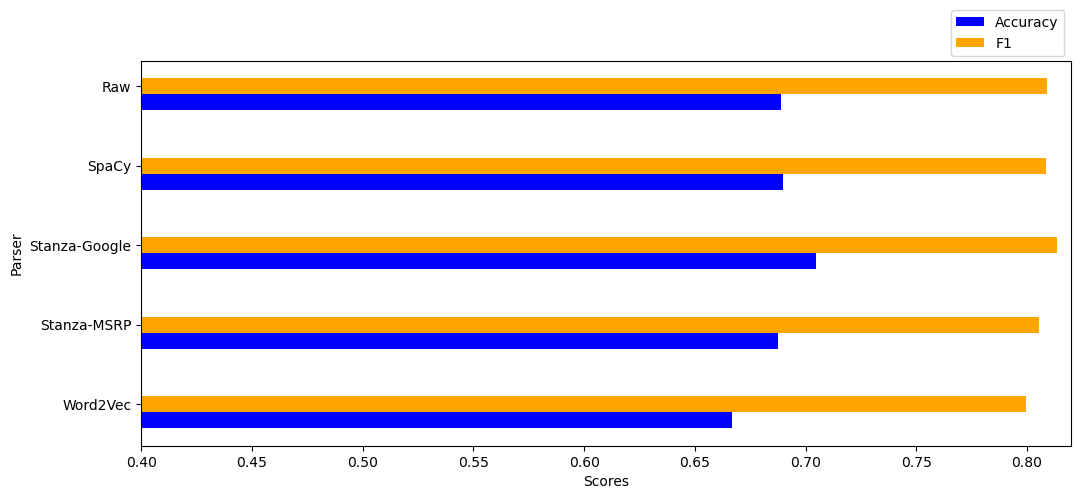

In [96]:
# create data
x = np.arange(5)
acc = [ accuracy_score(y, y_pred_word2vec), accuracy_score(y, y_pred), accuracy_score(y, y_pred_pretrained), accuracy_score(y_spacy, y_pred_spacy), accuracy_score(y_raw, y_pred_raw)]
f1 = [f1_score(y, y_pred_word2vec), f1_score(y, y_pred), f1_score(y, y_pred_pretrained), f1_score(y, y_pred_spacy), f1_score(y, y_pred_raw)]
width = 0.2
  
# plot data in grouped manner of bar type
# plt.barh(x-0.2, acc, width, color='blue')
# plt.barh(x, f1, width, color='orange')
# plt.yticks(x, ['Stanza-MSRP', 'Stanza-Google', 'SpaCy', 'Raw'])
# plt.ylabel("Parser")
# plt.xlabel("Scores")
# plt.legend(["Accuracy", "F1"], loc="upper right", bbox_to_anchor=(1, 1.15))
# plt.show()

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlim([0.4, 0.82])
ax.barh(x-0.2, acc, width, color='blue')
ax.barh(x, f1, width, color='orange')
ax.set_yticks(x, ['Word2Vec', 'Stanza-MSRP', 'Stanza-Google', 'SpaCy', 'Raw'])
plt.ylabel("Parser")
plt.xlabel("Scores")
ax.legend(["Accuracy", "F1"], loc="upper right", bbox_to_anchor=(1, 1.15))
plt.show()



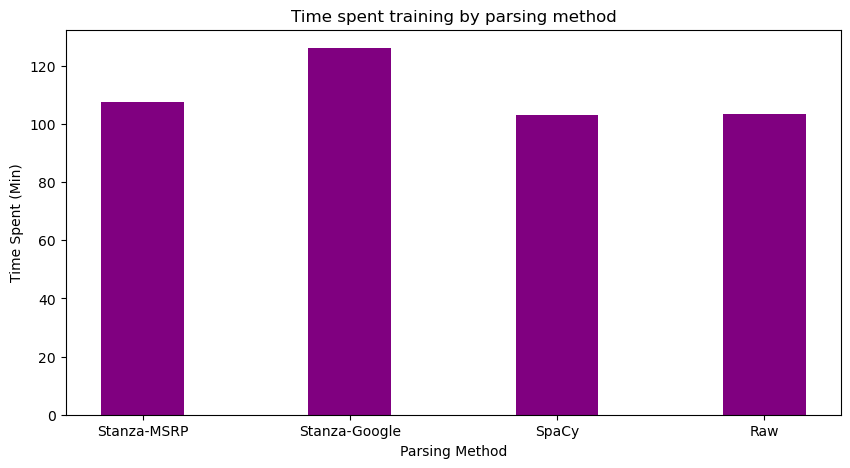

In [97]:
data = {'Stanza-MSRP':float(stanza_msrp_time.total_seconds()), 'Stanza-Google':float(stanza_pretrain_time.total_seconds()), 'SpaCy':float(spacy_time.total_seconds()),
        'Raw':float(raw_time.total_seconds())}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='purple',
        width = 0.4)
 
plt.xlabel("Parsing Method")
plt.ylabel("Time Spent (Min)")
plt.title("Time spent training by parsing method")
plt.show()

In [98]:
print(stanza_msrp_time.total_seconds())
print(stanza_pretrain_time.total_seconds())
print(spacy_time.total_seconds())
print(raw_time.total_seconds())

107.559148
126.094835
103.050888
103.244946
